# **1. Data Preprocessing.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing necessary libraries for preprocessing and modeling.**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import string
import re

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Downloading required NLTK Resources.
print("Downloading NLTK resources.")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Loading the train, test, validation Dataset.**

In [4]:
# Defining the column headers.
header_list = [
    "id", "label", "statement", "subject", "speaker",
    "speaker_job", "speaker_state", "speaker_affiliation",
    "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts", "context"
]

# Loading the train, test, validation Dataset.
print("\nLoading dataset.")
train_data = pd.read_csv('/content/drive/MyDrive/SMA_Project/raw/train.tsv', sep='\t', names=header_list)
test_data = pd.read_csv('/content/drive/MyDrive/SMA_Project/raw/test.tsv', sep='\t', names=header_list)
val_data = pd.read_csv('/content/drive/MyDrive/SMA_Project/raw/valid.tsv', sep='\t', names=header_list)

# Combining datasets.
combined_data = pd.concat([train_data, test_data, val_data], ignore_index=True)

# Saving combined data to a new file.
combined_data.to_csv('/content/drive/MyDrive/SMA_Project/raw/combined_data.csv', index=False)

print("\nCombined dataset saved as 'combined_data.csv'.")


Loading dataset.

Combined dataset saved as 'combined_data.csv'.


**Displaying basic information about the combined dataset.**

Deleting the id coloumn, as its just a name of file so its not useful.

In [5]:
combined_data.drop(['id'], axis=1, inplace=True)
combined_data.columns

Index(['label', 'statement', 'subject', 'speaker', 'speaker_job',
       'speaker_state', 'speaker_affiliation', 'barely_true_counts',
       'false_counts', 'half_true_counts', 'mostly_true_counts',
       'pants_on_fire_counts', 'context'],
      dtype='object')

In [6]:
# Adjust the index to start from 1
combined_data.index = combined_data.index + 1
combined_data.head()

,label,statement,subject,speaker,speaker_job,speaker_state,speaker_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
1,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
2,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
3,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
4,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
5,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [7]:
print("Combined Dataset Info:")
print(combined_data.info())

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 1 to 12791
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 12791 non-null  object 
 1   statement             12791 non-null  object 
 2   subject               12789 non-null  object 
 3   speaker               12789 non-null  object 
 4   speaker_job           9223 non-null   object 
 5   speaker_state         10040 non-null  object 
 6   speaker_affiliation   12789 non-null  object 
 7   barely_true_counts    12789 non-null  float64
 8   false_counts          12789 non-null  float64
 9   half_true_counts      12789 non-null  float64
 10  mostly_true_counts    12789 non-null  float64
 11  pants_on_fire_counts  12789 non-null  float64
 12  context               12660 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1.3+ MB
None


In [8]:
print("\nCombined Dataset Head:")
print(combined_data.head())


Combined Dataset Head:
         label                                          statement  \
1        false  Says the Annies List political group supports ...   
2    half-true  When did the decline of coal start? It started...   
3  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
4        false  Health care reform legislation is likely to ma...   
5    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
1                            abortion    dwayne-bohac  State representative   
2  energy,history,job-accomplishments  scott-surovell        State delegate   
3                      foreign-policy    barack-obama             President   
4                         health-care    blog-posting                   NaN   
5                        economy,jobs   charlie-crist                   NaN   

  speaker_state speaker_affiliation  barely_true_counts  false_counts  \
1         Tex

Checking Null values.

In [9]:
np.sum(combined_data.isnull().any(axis=1))

4356

Length of data.

In [10]:
print('lenght of data is', len(combined_data))

lenght of data is 12791


Shape of data.

In [11]:
combined_data.shape

(12791, 13)

Missing Values Heatmap.

<Figure size 1200x600 with 0 Axes>

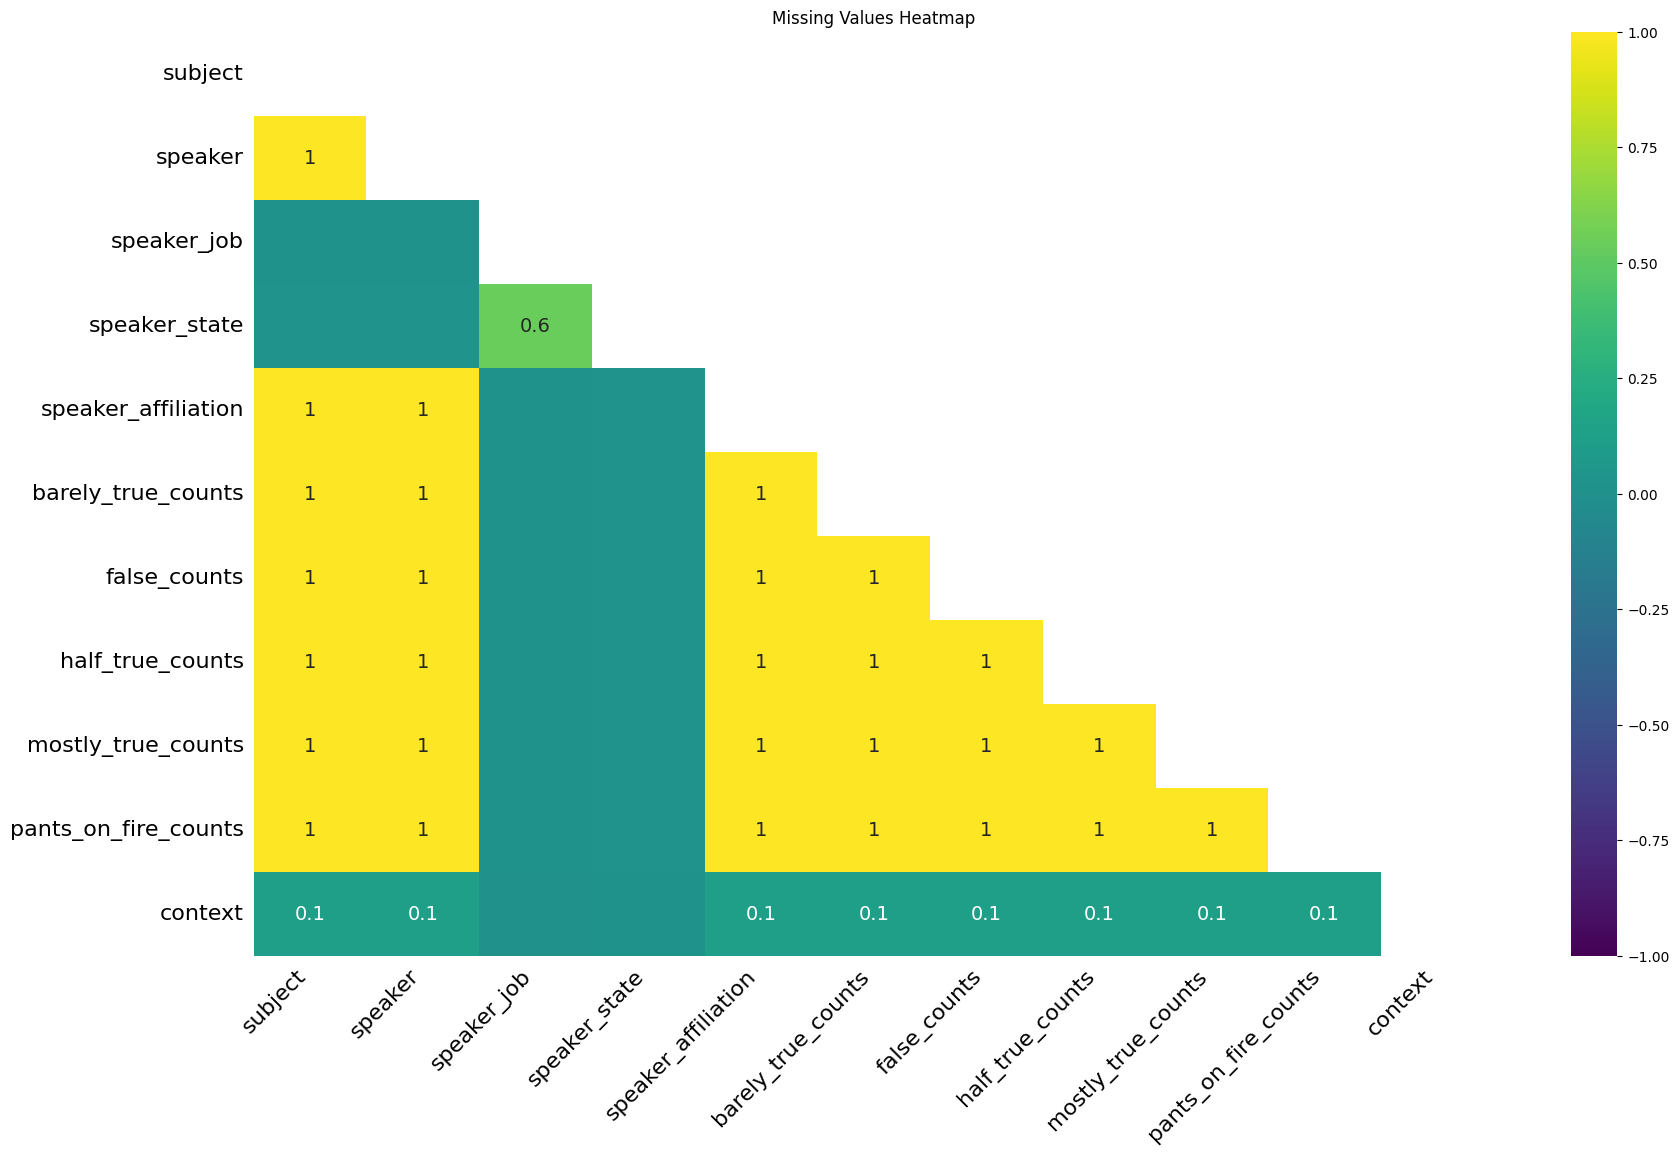

In [12]:
import missingno as msno

# Visualizing missing values using a heatmap.
plt.figure(figsize=(12, 6))
msno.heatmap(combined_data, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# **2. Data Cleaning.**

**Handling duplicate values.**

In [13]:
print("\nHandling duplicate and missing values.")

#Removing duplicates.
before=len(combined_data)
print('Rows of data before Deleting: ', before)
combined_data = combined_data.drop_duplicates()
after=len(combined_data)
print('Rows of data after Deleting: ', after)
print(f"Data after removing duplicates: {combined_data.shape}")
diff=before-after
print('Duplicated rows are: ', diff)


Handling duplicate and missing values.
Rows of data before Deleting:  12791
Rows of data after Deleting:  12790
Data after removing duplicates: (12790, 13)
Duplicated rows are:  1


**Handling missing values.**

In [14]:
# Checking for missing values.
missing_summary = combined_data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_summary)


Missing Values Summary:
label                      0
statement                  0
subject                    2
speaker                    2
speaker_job             3568
speaker_state           2751
speaker_affiliation        2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
dtype: int64


In [15]:
# Replacing empty strings and values with NaN.
combined_data.replace("", np.nan, inplace=True)
combined_data.replace('', np.nan, inplace=True)

# Replacing missing values with 'Unknown'.
combined_data['subject']= combined_data['subject'].replace(np.nan, 'Unknown')
combined_data['speaker']= combined_data['speaker'].replace(np.nan, 'Unknown')
combined_data['speaker_job']= combined_data['speaker_job'].replace(np.nan, 'Unknown')
combined_data["speaker_state"]= combined_data["speaker_state"].replace(np.nan, 'Unknown')
combined_data['speaker_affiliation']= combined_data['speaker_affiliation'].replace(np.nan, 'Unknown')
affiliation_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
combined_data[affiliation_columns] = combined_data[affiliation_columns].fillna(0)
combined_data['context']= combined_data['context'].replace(np.nan, 'Unknown')

combined_data.isnull().sum()

,0
label,0
statement,0
subject,0
speaker,0
speaker_job,0
speaker_state,0
speaker_affiliation,0
barely_true_counts,0
false_counts,0
half_true_counts,0


**Data After Cleaning.**

In [16]:
# Printing dataset summary after cleaning.
print("\nData after handling missing values:")
print(combined_data.info())


Data after handling missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 12790 entries, 1 to 12791
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 12790 non-null  object 
 1   statement             12790 non-null  object 
 2   subject               12790 non-null  object 
 3   speaker               12790 non-null  object 
 4   speaker_job           12790 non-null  object 
 5   speaker_state         12790 non-null  object 
 6   speaker_affiliation   12790 non-null  object 
 7   barely_true_counts    12790 non-null  float64
 8   false_counts          12790 non-null  float64
 9   half_true_counts      12790 non-null  float64
 10  mostly_true_counts    12790 non-null  float64
 11  pants_on_fire_counts  12790 non-null  float64
 12  context               12790 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1.4+ MB
None


In [17]:
print("\nCombined Dataset Head:")
combined_data.head()


Combined Dataset Head:


,label,statement,subject,speaker,speaker_job,speaker_state,speaker_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
1,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
2,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
3,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
4,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release
5,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


# **3. Data Transformation.**

**Binary Classification Transformation.**

In [18]:
# Mapping the labels into two categories: 'true' and 'false' for combined_data.
print("\nTransforming Labels for Binary Classification.")
combined_data['label'] = combined_data['label'].apply(lambda x: 'true' if x in ['true', 'mostly-true', 'half-true'] else 'false')
print("\nLabel Distribution:")
print(combined_data['label'].value_counts())


Transforming Labels for Binary Classification.

Label Distribution:
label
true     7133
false    5657
Name: count, dtype: int64


In [19]:
combined_data.head()

,label,statement,subject,speaker,speaker_job,speaker_state,speaker_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
1,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
2,true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
3,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
4,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release
5,true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


**Visualizing Label Distribution.**

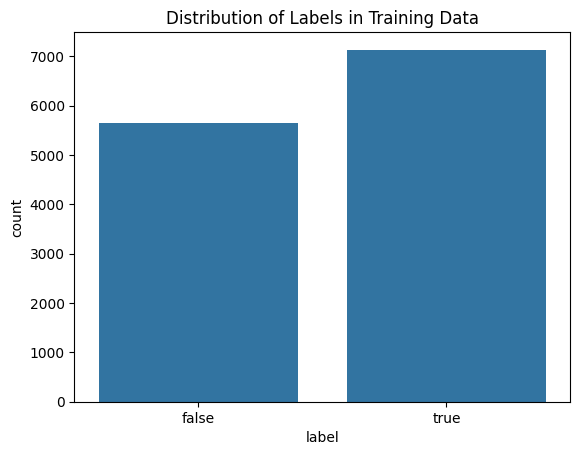

In [20]:
# Visualizing the distribution of labels in train_val_data.
sns.countplot(data=combined_data, x='label')
plt.title('Distribution of Labels in Training Data')
plt.show()

# **4. Text Preprocessing.**

**Defining Text Preprocessing Function.**

In [21]:
print("\nPerforming Text Preprocessing.")
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    # Lowercasing the text.
    text = text.lower()
    # Removing URLs.
    text = re.sub(r'http\S+', '', text)
    # Removing emails.
    text = re.sub(r'\S+@\S+', '', text)
    # Removing numbers.
    text = re.sub(r'\d+', '', text)
    # Removing punctuation.
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Removing repeating characters.
    text = re.sub(r'(.)\1+', r'\1', text)
    # Removing extra whitespaces.
    text = text.strip()
    # Tokenizing using RegexpTokenizer.
    tokens = tokenizer.tokenize(text)
    # Removing stopwords.
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Joining tokens back into a single string.
    text =  ' '.join(tokens)
    return text

# Applying the text preprocessing function.
combined_data['cleaned_statement'] = combined_data['statement'].apply(preprocess_text)
print("\nSample Cleaned Data:")
print(combined_data[['statement', 'cleaned_statement']].head())
print(combined_data[['statement', 'cleaned_statement']].tail())


Performing Text Preprocessing.

Sample Cleaned Data:
                                           statement  \
1  Says the Annies List political group supports ...   
2  When did the decline of coal start? It started...   
3  Hillary Clinton agrees with John McCain "by vo...   
4  Health care reform legislation is likely to ma...   
5  The economic turnaround started at the end of ...   

                                   cleaned_statement  
1  say anies list political group suports thirdtr...  
2  decline coal start started natural gas tok sta...  
3  hilary clinton agres john mcain voting give ge...  
4  health care reform legislation likely mandate ...  
5               economic turnaround started end term  
                                               statement  \
12787  For the first time in more than a decade, impo...   
12788  Says Donald Trump has bankrupted his companies...   
12789  John McCain and George Bush have "absolutely n...   
12790  A new poll shows 62 percent supp

# **5. Exploratory Data Analysis (EDA).**

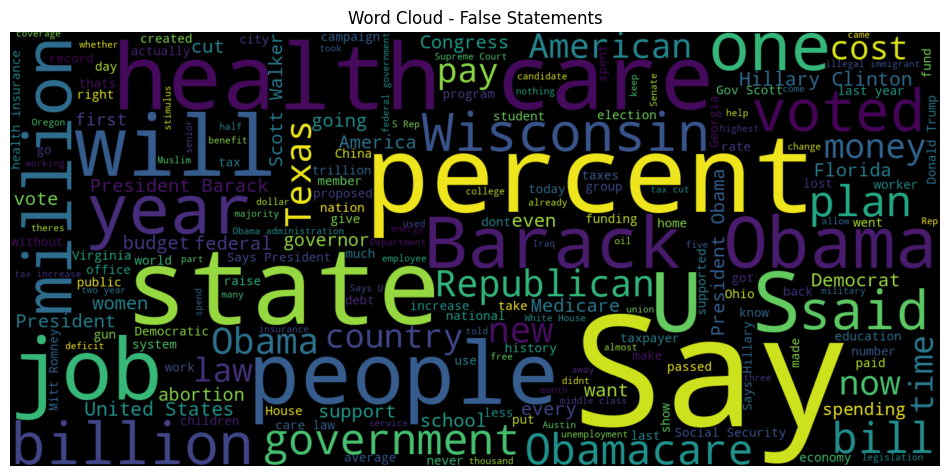

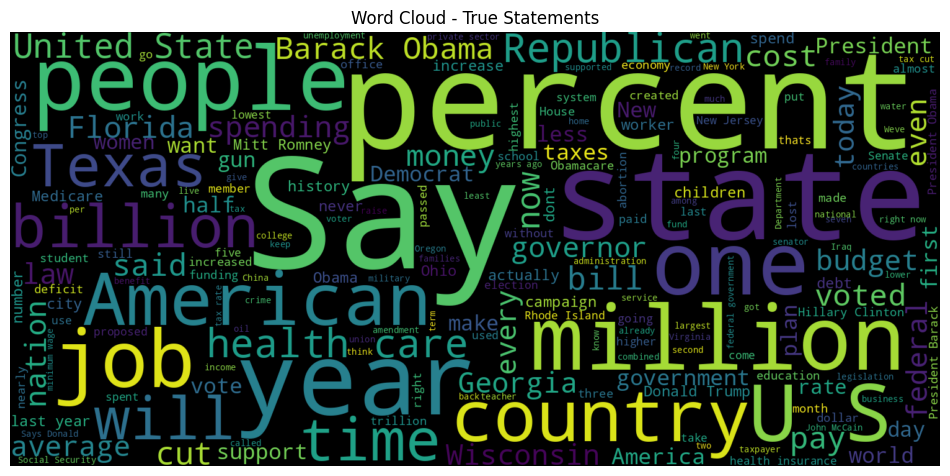

In [22]:
# Exploratory Data Analysis (EDA) with Word Clouds.

# Generating word clouds for each label in combined_data.
labels = combined_data['label'].unique()
for label in labels:
    data_subset = combined_data[combined_data['label'] == label]
    text = ' '.join(data_subset['statement'].astype(str))
    wordcloud = WordCloud(width=1500, height=700, max_font_size=250).generate(text)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {label.capitalize()} Statements')
    plt.show()

# **6. Word Frequency Analysis.**

**Analyzing Word Frequencies.**

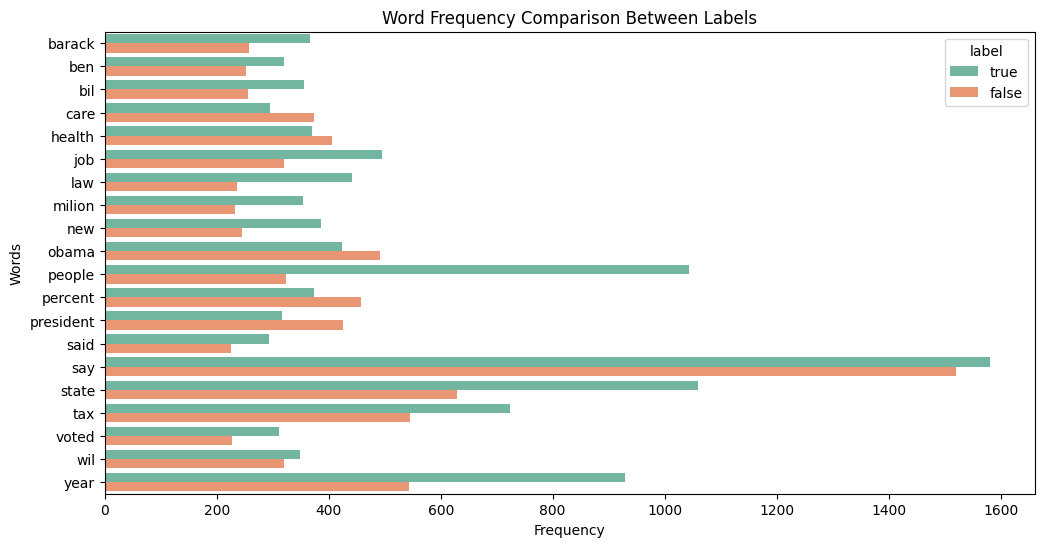

In [23]:
# Creating separate subsets for true and false statements.
true_statements = combined_data[combined_data['label'] == 'true']['cleaned_statement']
false_statements = combined_data[combined_data['label'] == 'false']['cleaned_statement']

# Vectorizing the text.
vectorizer = CountVectorizer(stop_words='english', max_features=20)
true_words = vectorizer.fit_transform(true_statements)
false_words = vectorizer.fit_transform(false_statements)

# Getting word frequencies.
true_word_counts = np.array(true_words.sum(axis=0))[0]
false_word_counts = np.array(false_words.sum(axis=0))[0]
words = vectorizer.get_feature_names_out()

# Create a DataFrame for visualization
word_freq_df = pd.DataFrame({'word': words, 'true': true_word_counts, 'false': false_word_counts}).melt(id_vars='word', var_name='label', value_name='frequency')

# Plotting the word frequencies.
plt.figure(figsize=(12, 6))
sns.barplot(data=word_freq_df, x='frequency', y='word', hue='label', palette='Set2')
plt.title('Word Frequency Comparison Between Labels')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

**Top 25 Most Frequent Words.**

In [24]:
# Analyzing word frequencies in combined_data.
all_words = ' '.join(combined_data['cleaned_statement']).split()
word_counts = pd.Series(all_words).value_counts()

#Displaying the top 25 most frequent words.
print("Top 25 most frequent words in training data:")
print(word_counts.head(25))

Top 25 most frequent words in training data:
say          3102
state        1690
percent      1501
year         1474
tax          1269
obama         878
job           816
president     799
health        776
people        747
milion        674
would         664
care          655
u             638
wil           601
new           599
one           588
ben           573
american      551
time          524
country       518
bil           503
bilion        499
al            484
texas         484
Name: count, dtype: int64


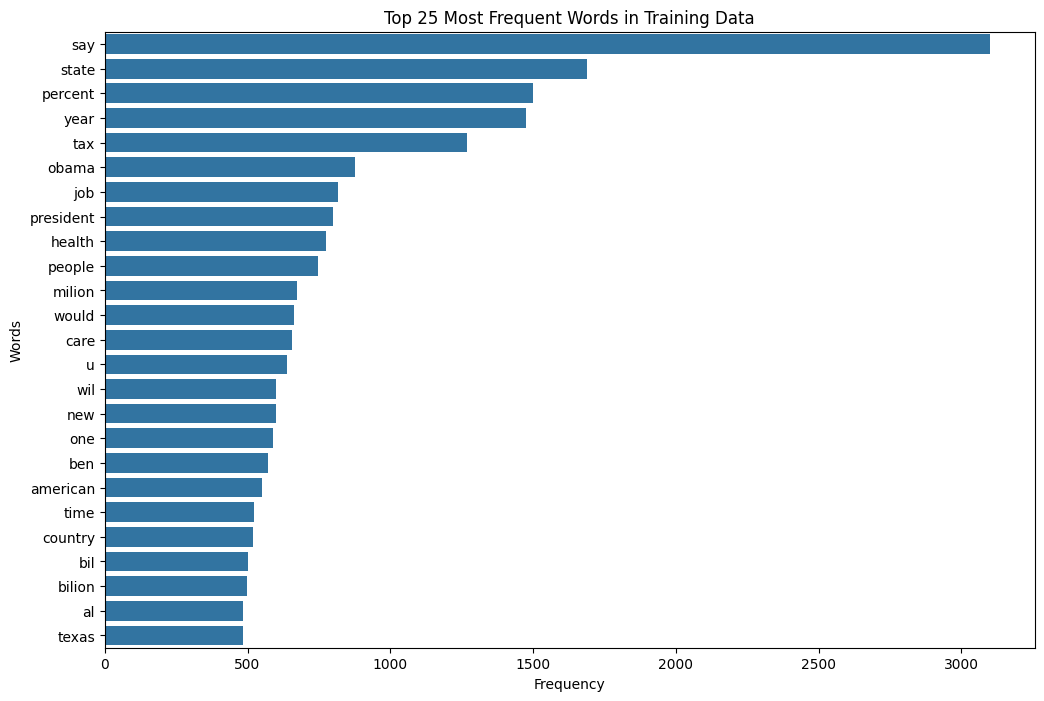

In [25]:
# Visualizing the top 25 words.
plt.figure(figsize=(12, 8))
sns.barplot(y=word_counts.head(25).index, x=word_counts.head(25).values)
plt.title('Top 25 Most Frequent Words in Training Data')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# **7. Topic Modeling with LDA.**


Performing Topic Modeling with LDA.

Applying LDA for Topic Modeling and Evaluating Coherence.

LDA with 1 Topics:
Topic 1: people, health, president, job, obama, tax, year, percent, state, say
Coherence Score for 1 Topics: 0.4335

LDA with 2 Topics:
Topic 1: rate, milion, ben, country, people, say, job, year, state, percent
Topic 2: cut, republican, obama, bil, state, bilion, care, health, tax, say
Coherence Score for 2 Topics: 0.4967

LDA with 3 Topics:
Topic 1: texas, country, people, milion, rate, say, year, job, state, percent
Topic 2: plan, clinton, said, bil, republican, voted, tax, care, health, say
Topic 3: percent, budget, barack, bilion, tax, year, state, president, say, obama
Coherence Score for 3 Topics: 0.5194

LDA with 4 Topics:
Topic 1: city, texas, milion, people, year, say, rate, state, percent, job
Topic 2: law, insurance, said, clinton, bil, voted, republican, care, health, say
Topic 3: obamas, debt, united, year, percent, state, barack, say, president, obama
Topic

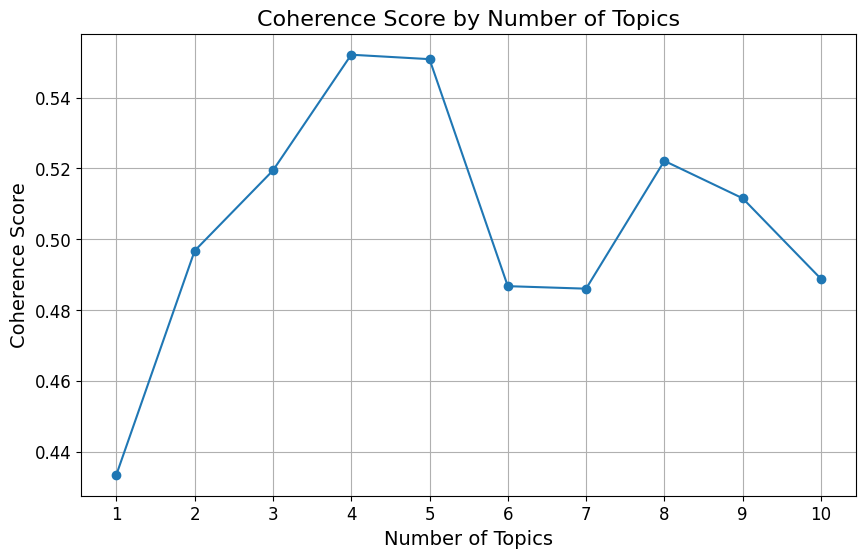


Optimal Number of Topics: 4

Training Final LDA Model.
Topic 1: city, texas, milion, people, year, say, rate, state, percent, job
Assign a label for Topic 1: Regional Economics and Employment Trends
Topic 2: law, insurance, said, clinton, bil, voted, republican, care, health, say
Assign a label for Topic 2: Healthcare Legislation and Political Dynamics
Topic 3: obamas, debt, united, year, percent, state, barack, say, president, obama
Assign a label for Topic 3: National Debt and Obama’s Presidency
Topic 4: pay, milion, budget, bilion, cut, state, percent, say, year, tax
Assign a label for Topic 4: Taxation and Government Budgeting

Generating Word Clouds for Topics.


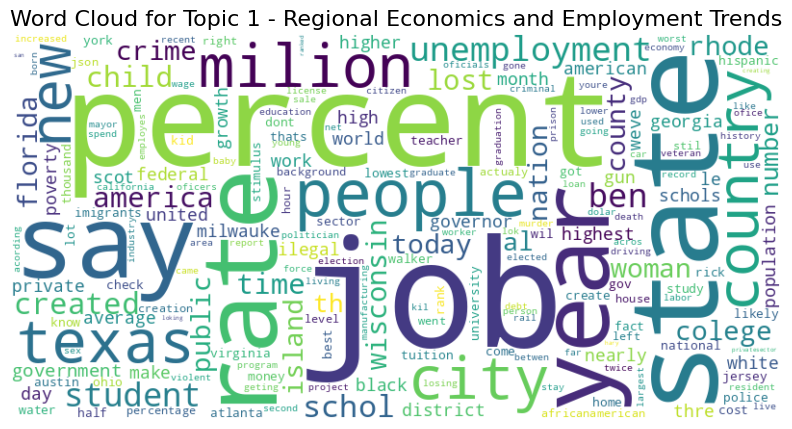

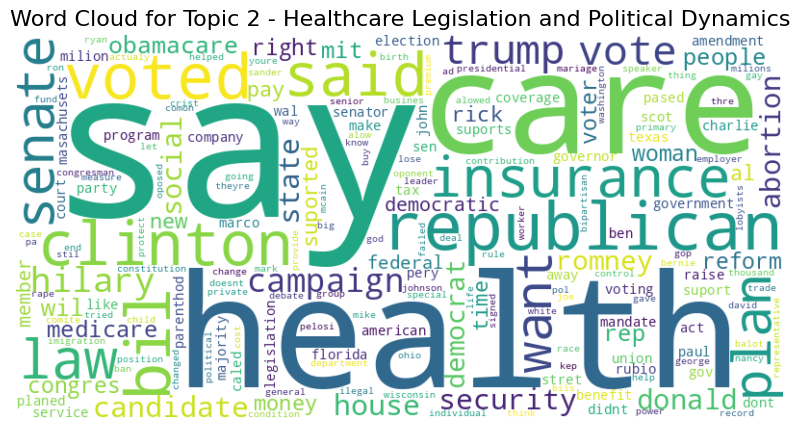

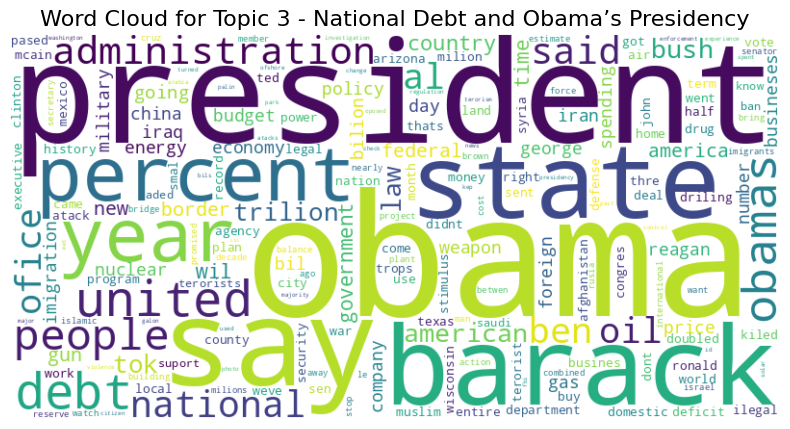

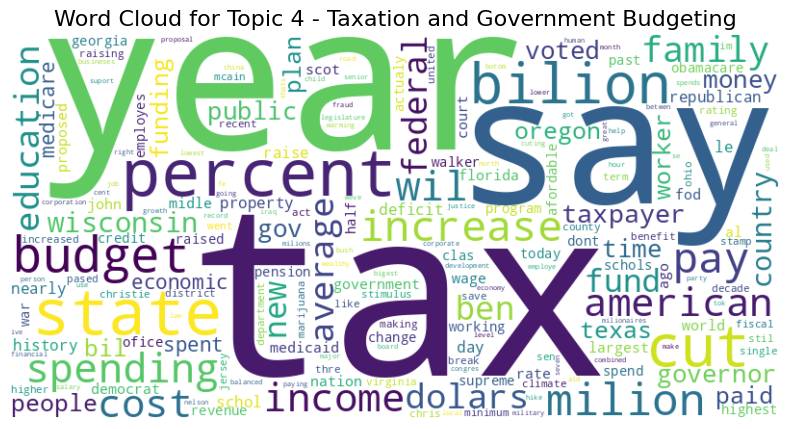

In [26]:
#Preparing Data for LDA
# Tokenizing the 'cleaned_statement' column.
combined_data['tokenized_statement'] = combined_data['cleaned_statement'].apply(lambda x: x.split())

# Preparing Dictionary and Corpus for Gensim Coherence Score.
dictionary = Dictionary(combined_data['tokenized_statement'])
corpus = [dictionary.doc2bow(text) for text in combined_data['tokenized_statement']]

# Vectorizing Data for LDA (using cleaned_statement directly as it contains strings).
print("\nPerforming Topic Modeling with LDA.")
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(combined_data['cleaned_statement'])

# Function to Compute Coherence Score.
def compute_coherence(lda_model, corpus, dictionary):
    topics = lda_model.components_
    topic_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]] for topic in topics]
    coherence_model = CoherenceModel(topics=topic_words, texts=combined_data['tokenized_statement'], dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Applying LDA and Evaluating Coherence for Different Numbers of Topics.
print("\nApplying LDA for Topic Modeling and Evaluating Coherence.")
coherence_scores = []
for k in range(1, 11):
    # Experimenting with 1 to 10 topics.
    print(f"\nLDA with {k} Topics:")
    lda_model = LatentDirichletAllocation(n_components=k, random_state=24)
    lda_model.fit(dtm)

    # Printing Top Words for Each Topic.
    for i, topic in enumerate(lda_model.components_):
        top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
        print(f"Topic {i+1}: {', '.join(top_words)}")

    # Computing Coherence Score.
    coherence = compute_coherence(lda_model, corpus, dictionary)
    coherence_scores.append(coherence)
    print(f"Coherence Score for {k} Topics: {coherence:.4f}")

# Plotting Coherence Scores.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), coherence_scores, marker='o')
plt.title('Coherence Score by Number of Topics', fontsize=16)
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

# Selecting the Optimal Number of Topics.
optimal_k = coherence_scores.index(max(coherence_scores)) + 1
print(f"\nOptimal Number of Topics: {optimal_k}")

# Training Final LDA Model with Optimal Number of Topics.
print("\nTraining Final LDA Model.")
final_lda_model = LatentDirichletAllocation(n_components=optimal_k, random_state=24)
final_lda_model.fit(dtm)

# Extracting Topics and Assign Labels.
topics = final_lda_model.components_
topic_labels = []
for idx, topic in enumerate(topics):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx + 1}: {', '.join(top_words)}")
    # Prompt for manual labeling.
    label = input(f"Assign a label for Topic {idx + 1}: ")
    topic_labels.append(label)

# Generating Word Clouds for Topics.
print("\nGenerating Word Clouds for Topics.")
for idx, topic in enumerate(topics):
    word_freq = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.title(f"Word Cloud for Topic {idx + 1} - {topic_labels[idx]}", fontsize=16)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# **8. Saving Preprocessed Data.**

In [27]:
# Save the current state of the combined_data DataFrame to a CSV file.
combined_data.to_csv('/content/drive/MyDrive/SMA_Project/raw/combined_data_preprocessed.csv', index=False)

print("\nPreprocessed dataset saved as 'combined_data_preprocessed.csv'.")


Preprocessed dataset saved as 'combined_data_preprocessed.csv'.


In [28]:
combined_data.head()

,label,statement,subject,speaker,speaker_job,speaker_state,speaker_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,cleaned_statement,tokenized_statement
1,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anies list political group suports thirdtr...,"[say, anies, list, political, group, suports, ..."
2,true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start started natural gas tok sta...,"[decline, coal, start, started, natural, gas, ..."
3,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hilary clinton agres john mcain voting give ge...,"[hilary, clinton, agres, john, mcain, voting, ..."
4,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation likely mandate ...,"[health, care, reform, legislation, likely, ma..."
5,true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,economic turnaround started end term,"[economic, turnaround, started, end, term]"
